## Applying Homogeneous Field Correction after identifying bad sensors

### Import the necessary modules
Below are the required Python modules to be imported

In [1]:
import mne
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import array
from pprint import pprint
import json
import os.path as op
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
    write_meg_calibration,
    write_meg_crosstalk,
    write_raw_bids,
)
from mne_bids.stats import count_events

#### The resampled data is saved as per the BIDS Format in the Sub1_BIDS folder. To import the data in this workspace the following steps will be followed.

#### File overview

The chapter relies on the file (embedded in the BIDS structure):

< BIDS_ROOT >/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif

#### Specify your BIDS parameters along with the BIDS folder path

In [2]:
subject = '01'  
session = '01'  
task = 'SpAtt'
run = '01'  
meg_suffix = 'meg'
meg_extension = '.fif'
events_suffix = 'events'
events_extension = '.tsv'

data_path='/home/rakshita/rds_folders/Sproject3/OPM_data'
bids_root = op.join(data_path, "Sub1_BIDS")
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=meg_suffix, extension=meg_extension, root=bids_root)

#### Create a Derivative folder inside the BIDS Folder (Sub1_BIDS) to save the processed data in future

In [3]:
deriv_root = op.join(bids_root, 'derivatives/preprocessing')  # output path

deriv_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=meg_suffix, root=deriv_root).mkdir()

deriv_fname = bids_path.basename.replace('meg', 'raw_hfc') # output filename
deriv_file_1 = op.join(deriv_path.directory, deriv_fname)

#### Now Read the Raw Data

In [4]:
raw = read_raw_bids(bids_path=bids_path, verbose=False,extra_params={'preload':True})

#### Idenfity the faulty sensors

In the present context  bad sensors will be identified based on the average power spectral density of the sensors calculated over the entire range of frequency. First the average PSD will be obtained for all the sensors and a histogram will be plotted. Sensors having high PSD value crossing a predefined threshold will be rejected and hence will not contribute towards HFC filtering.

In [5]:
n_fft = 2000
raw_PSD = raw.compute_psd(method="welch", fmin=0.1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2))
psds = raw_PSD.get_data() # units are in T^2/Hz
freqs = raw_PSD.freqs 
psd_db = [10 * np.log10(psd * 1e30) for psd in psds] # Ref power: 1fT^2=1e-30T^2
average_power = np.mean(psd_db, axis=1)

Effective window size : 2.000 (s)


Plotting power spectral density (dB=True).


/home/rakshita/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


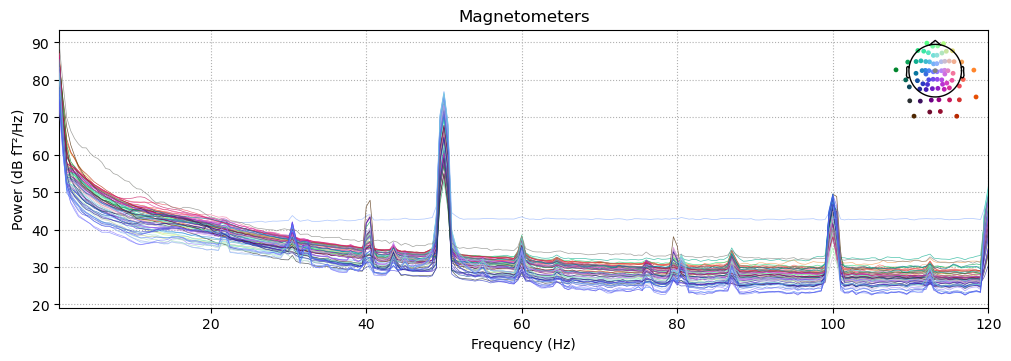

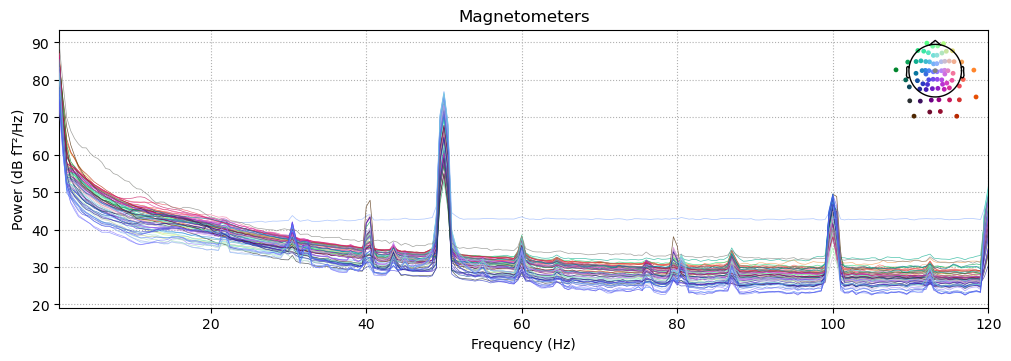

In [6]:
raw_PSD.plot()

#### Histogram Plot

Text(0.5, 1.0, 'Histogram of Average Power Across Sensors')

<Figure size 640x480 with 0 Axes>

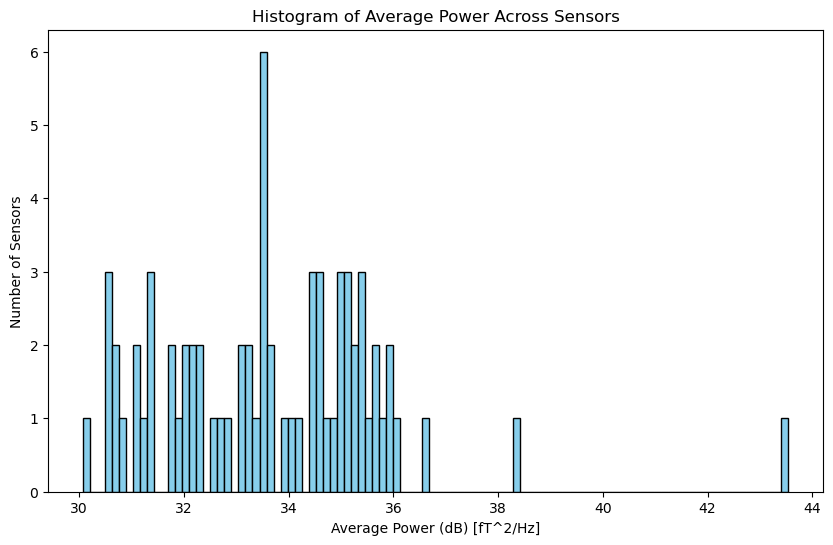

In [7]:
%matplotlib inline
plt.clf()
plt.figure(figsize=(10, 6))
plt.hist(average_power, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Average Power (dB) [fT^2/Hz]')
plt.ylabel('Number of Sensors')
plt.title('Histogram of Average Power Across Sensors')

It is evident from the histogram that two sensors fall apart with respect to the average PSD, hence we set a cutoff at 36.2dB and the sensors beyond that will be rejected.

#### Sensors Crossing the 36.2 dB threshold

Here we will identify the sensors crossing the threshold defined above

In [8]:
sensor_names = raw_PSD.ch_names
sensors_above_threshold = [sensor_names[i] for i, avg in enumerate(average_power) if avg > 36.2]
print(sensors_above_threshold)

['L503_bz-s79', 'R106_bz-s3', 's16_bz']


#### Mark the above sensors as the bad sensors

In [9]:
raw1=raw.copy()
raw1.info['bads']=sensors_above_threshold
#raw.info["bads"].extend(["L507_bz-s70"])

#### Before doing HFC plot the PSD excluding the bad sensors

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


/home/rakshita/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


<Figure size 640x480 with 0 Axes>

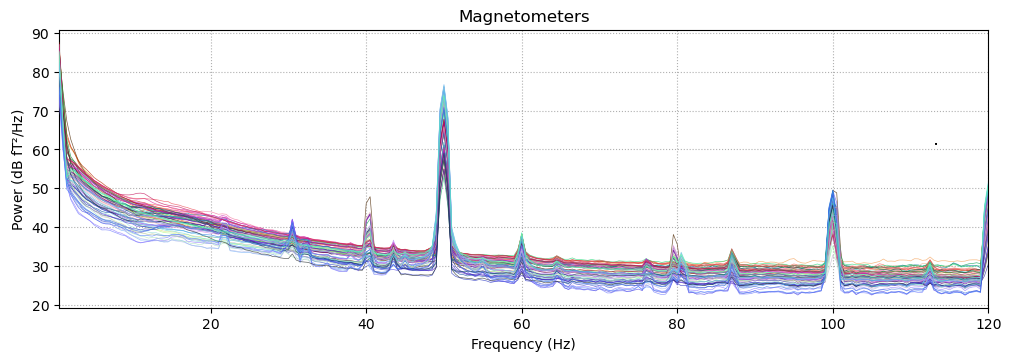

In [11]:
%matplotlib inline
plt.clf()
raw1_PSD = raw1.compute_psd(method="welch", fmin=0.1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2)).plot(exclude='bads')
plt.ylim(20, 90)
# Save the plot
output_file = "PSD_before_HFC.png"
plt.savefig(output_file, dpi=600, bbox_inches="tight")
plt.show()

#### Plot of the raw data before pre-processing

For brevity, we will plot data from a subset of sensors, selecting every 5th sensor.

[Text(0.5, 1.0, 'Before Applying HFC'),
 (-3000.0, 3000.0),
 (0.0, 2443.0),
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Amplitude (pT)')]

<Figure size 640x480 with 0 Axes>

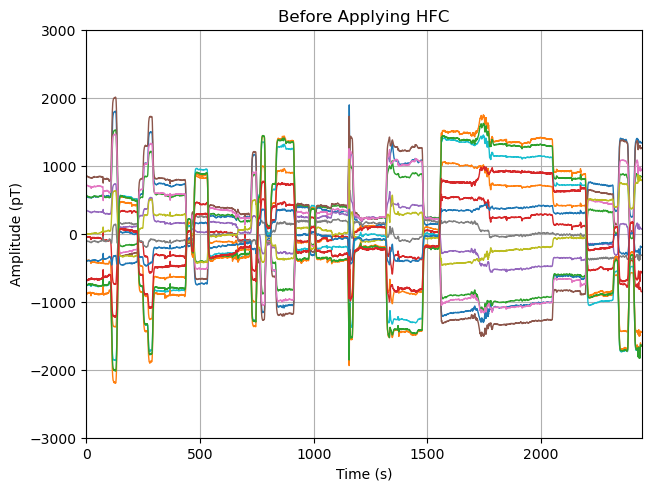

In [12]:
picks = mne.pick_types(raw1.info, meg=True,exclude='bads')

amp_scale = 1e12  # Converting to pico Tesla(pT)
stop = len(raw1.times) - 300
step = 500
data_ds, time_ds = raw1[picks[::5], :stop]
data_ds, time_ds = data_ds[:, ::step]* amp_scale , time_ds[::step]

plt.clf()
fig, ax = plt.subplots(layout="constrained")
plot_kwargs = dict(lw=1, alpha=1)
ax.plot(time_ds, data_ds.T - np.mean(data_ds, axis=1), **plot_kwargs)
ax.grid(True)
set_kwargs = dict(
    ylim=(-3000, 3000), xlim=time_ds[[0, -1]], xlabel="Time (s)", ylabel="Amplitude (pT)"
)
ax.set(title="Before Applying HFC", **set_kwargs)

### Interference rejection using Homogeneous Field Correction

In [13]:
raw2=raw1.copy()
projs = mne.preprocessing.compute_proj_hfc(raw2.info, order=2)
raw2.add_proj(projs).apply_proj(verbose="error")

8 projection items deactivated


<Raw | sub-01_ses-01_task-SpAtt_run-01_meg.fif, 71 x 2443460 (2443.5 s), ~1.29 GB, data loaded>

#### Plotting the raw data after applying HFC

[Text(0.5, 1.0, 'After HFC'),
 (-3000.0, 3000.0),
 (0.0, 2443.0),
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Amplitude (pT)')]

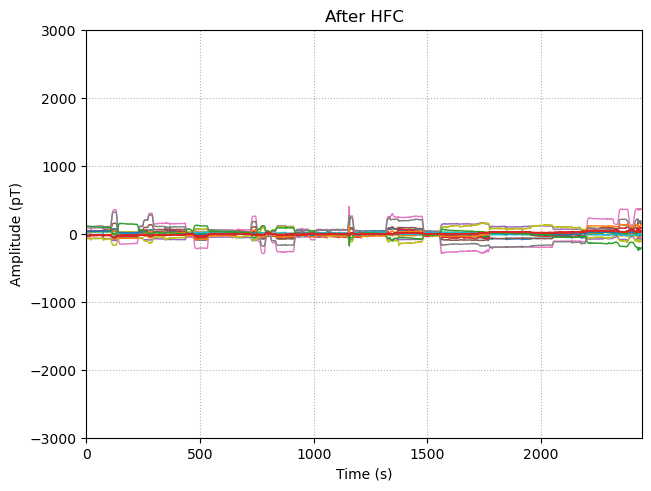

In [14]:
# plot
data_ds, _ = raw2[picks[::5], :stop]
data_ds = data_ds[:, ::step] * amp_scale

fig, ax = plt.subplots(layout="constrained")
ax.plot(time_ds, data_ds.T - np.mean(data_ds, axis=1), **plot_kwargs)
ax.grid(True, ls=":")
ax.set(title="After HFC", **set_kwargs)

### PSD after HFC

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

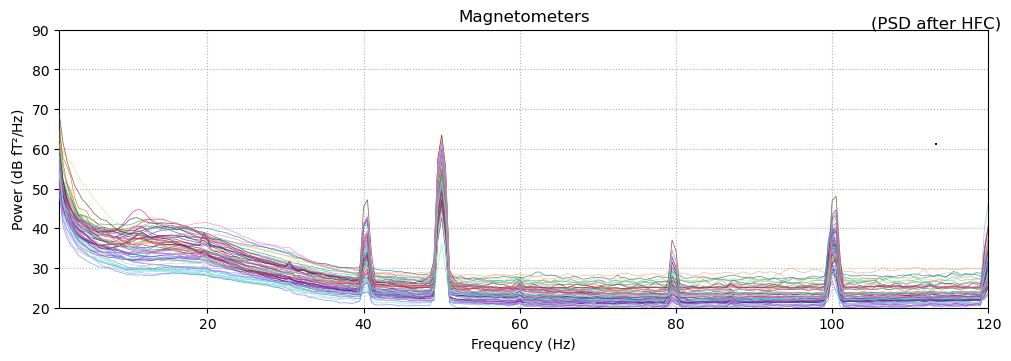

In [15]:
plt.clf()
%matplotlib inline
raw2_PSD = raw2.compute_psd(method="welch", fmin=1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2)).plot(show=False,exclude='bads')
# Add title and labels using Matplotlib
plt.title("(PSD after HFC)")
#plt.show()
for ax in raw2_PSD.axes:
    ax.set_ylim(20, 90) 

# Save the plot
output_file = "PSD_after_HFC.png"
plt.savefig(output_file, dpi=600, bbox_inches="tight")
plt.show()

### Removing the other high frequency interferences using Bandpass Filter.

The data will be bandpass filtered between 3-120Hz.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


[Text(0.5, 1.0, 'After HFC and bandpass(3-120Hz)'),
 (-10.0, 10.0),
 (0.0, 2443.0),
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Amplitude (pT)')]

<Figure size 640x480 with 0 Axes>

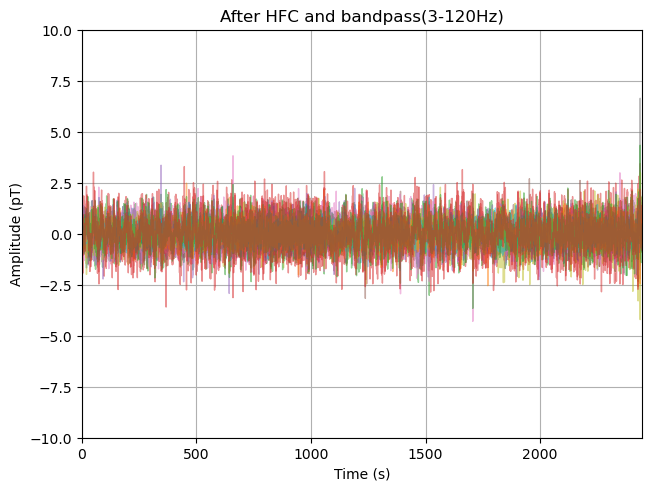

In [16]:
# notch
#raw.notch_filter(np.arange(50, 251, 50), notch_widths=4)
# bandpass
raw3=raw2.copy()
raw3.filter(3, 120, picks="meg")
# plot
data_ds, _ = raw3[picks[::5], :stop]
data_ds = data_ds[:, ::step] * amp_scale

plt.clf()
fig, ax = plt.subplots(layout="constrained")
plot_kwargs = dict(lw=1, alpha=0.5)
ax.plot(time_ds, data_ds.T - np.mean(data_ds, axis=1), **plot_kwargs)
ax.grid(True)
set_kwargs = dict(
    ylim=(-10, 10), xlim=time_ds[[0, -1]], xlabel="Time (s)", ylabel="Amplitude (pT)"
)
ax.set(title="After HFC and bandpass(3-120Hz)", **set_kwargs)

### Calculate PSD after HFC + Filtering(3-120Hz)

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


/home/rakshita/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Text(0.5, 1.0, 'HFC+ Bandpass (3-120Hz)')

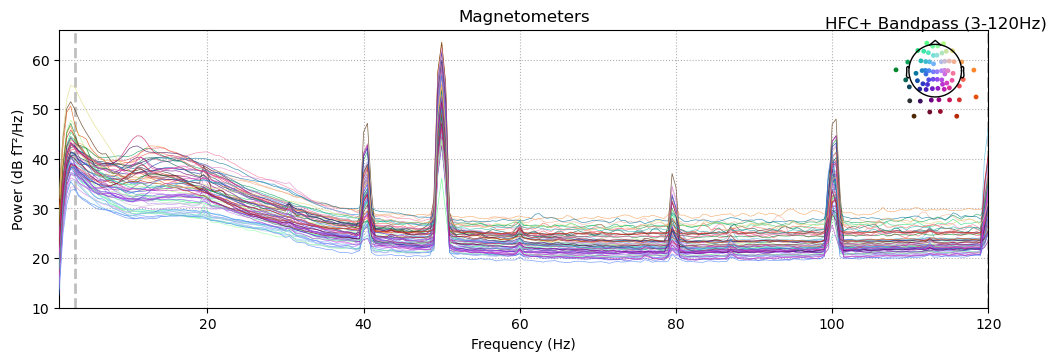

In [17]:
raw3_PSD = raw3.compute_psd(method="welch", 
                            fmin=1, 
                            fmax=120, 
                            picks="mag", 
                            n_fft=n_fft, 
                            n_overlap=int(n_fft/2))
raw3_PSD.plot(exclude='bads')
plt.title("HFC+ Bandpass (3-120Hz)")

### Indivudual Sensor PSD after HFC + Filtering (3-120Hz)

Effective window size : 2.000 (s)


<Figure size 640x480 with 0 Axes>

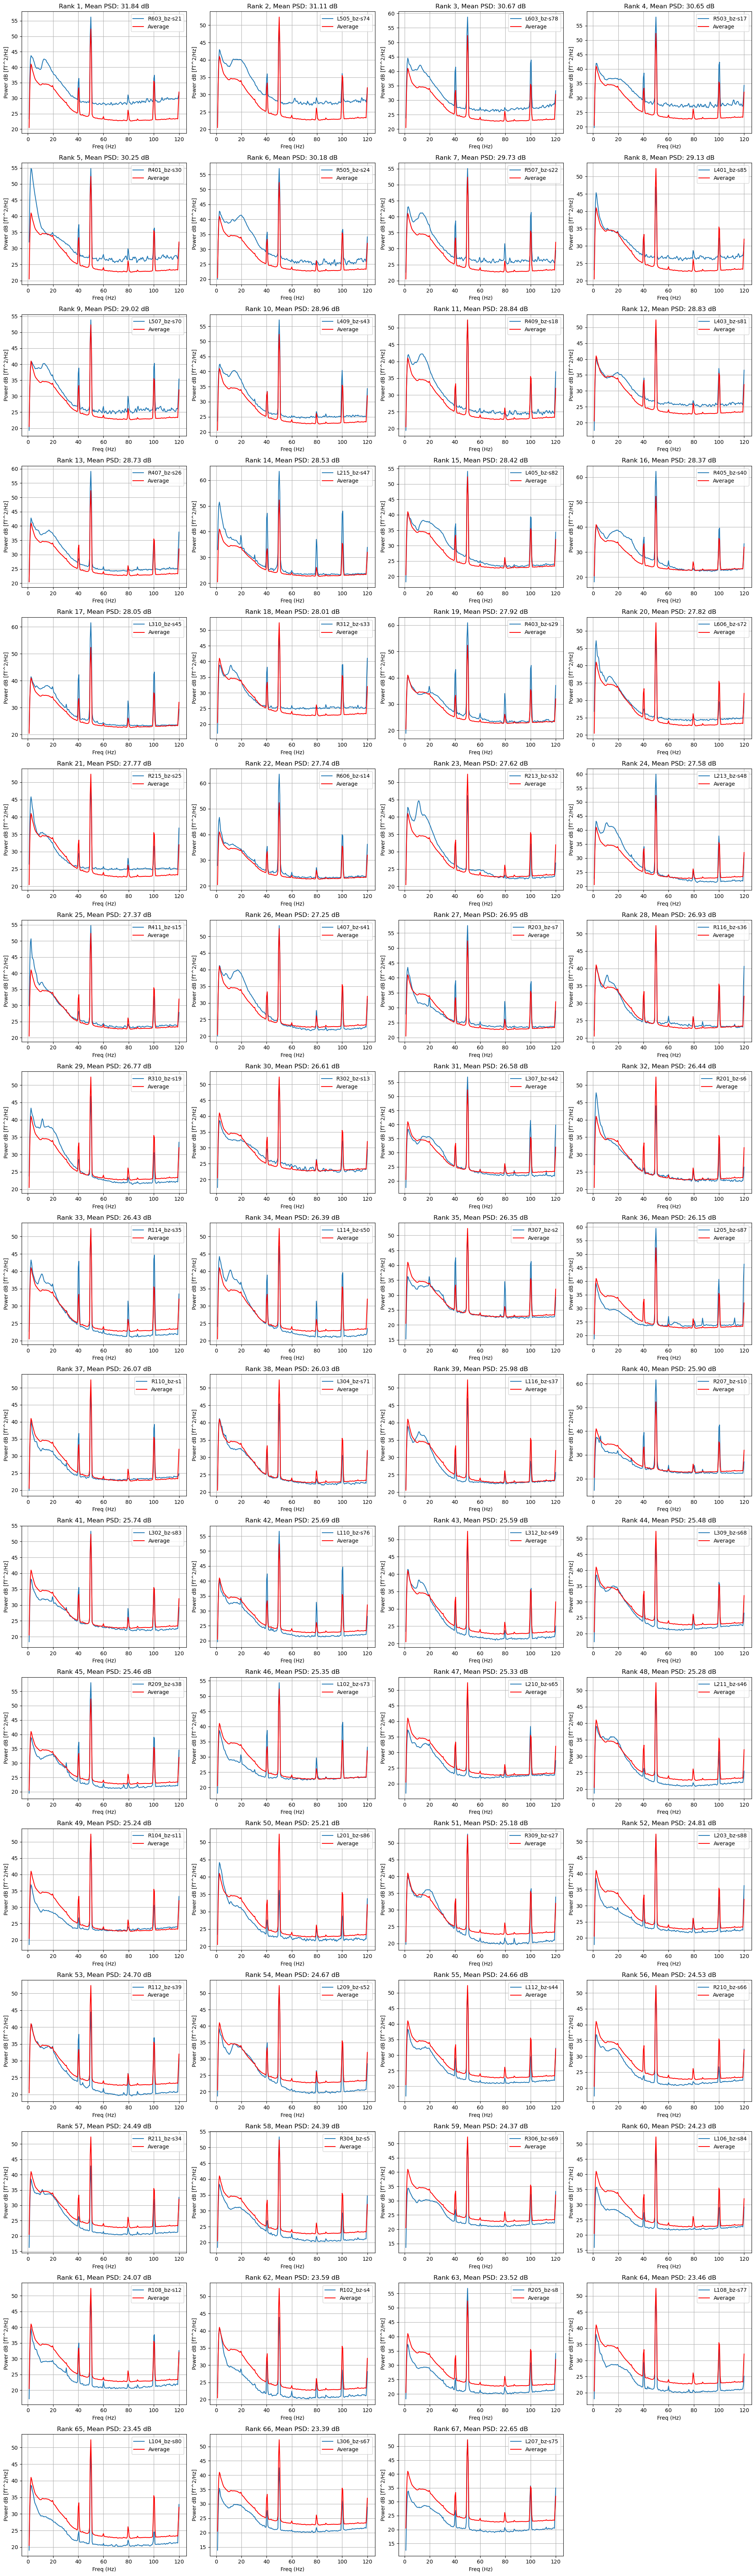

In [18]:
n_fft = 2000
raw_PSD = raw3.compute_psd(method="welch", fmin=1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2))
psds = raw_PSD.get_data() # units are in T^2/Hz
freqs = raw_PSD.freqs 


# Convert to db
avg_psd = [10 * np.log10(psd * 1e30) for psd in psds] # Ref power: 1fT^2=1e-30T^2
average_power = np.mean(avg_psd, axis=1)
## Get Only MEG channels
mag_channels = mne.pick_types(raw3.info, meg=True, stim=False)
channel_names = [raw3.info['ch_names'][i] for i in mag_channels]

ch_power_data = list(zip(channel_names, average_power, avg_psd))
ch_power_data_s = sorted(ch_power_data, key=lambda x: x[1], reverse=True) # Sorting by average power

s_channel_names = [channel for channel, power, psd in ch_power_data_s] #Sorted Channel names
s_average_power = [power for channel, power, psd in ch_power_data_s]
s_psds = [psd for channel, power, psd in ch_power_data_s]


n_channels = len(s_channel_names)
n_cols = 4  
n_rows = 17

ymin = 20 
ymax = 70 
grand_avg_psd = np.mean(s_psds, axis=0)

plt.clf()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for rank, (channel, avg_power, psd) in enumerate(ch_power_data_s):
    ax = axes[rank]
    ax.plot(freqs, psd, label=f'{channel}')
    ax.plot(freqs, grand_avg_psd, label='Average', color='red')
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Power dB [fT^2/Hz]')
    avg_psd_value = np.mean(psd)
    ax.set_title(f'Rank {rank + 1}, Mean PSD: {avg_psd_value:.2f} dB')
    #ax.set_ylim(ymin, ymax)
    ax.legend()
    ax.grid(True)

# Delete remaining unused subplots
for ax in axes[len(s_channel_names):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Store the filtered data within the derivatives folder of the BIDS directory.

In [ ]:
raw_hfc=raw3.copy()
raw_hfc.save(deriv_file_1, overwrite=True) 